# Spitfire Example: chemical explosive mode analysis of two-temperature ignition pathways

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from spitfire.chemistry.mechanism import ChemicalMechanismSpec
from spitfire.chemistry.flamelet import Flamelet
from spitfire.chemistry.analysis import explosive_mode_analysis
from spitfire.chemistry.library import Dimension, Library

In [2]:
mechanism = ChemicalMechanismSpec(cantera_xml='dme-bhagatwala.xml', group_name='dme-bhagatwala')

In [3]:
pressure = 101325.

air = mechanism.stream(stp_air=True)
air.TP = 1200., pressure
fuel = mechanism.stream('TPX', (300., pressure, 'CH3OCH3:1,CH4:1'))

npts_mixfrac = 128
nchi = 64
chist_vec = np.logspace(-4., 4., nchi)

flamelet_specs = {'mech_spec': mechanism,
                  'pressure': pressure,
                  'initial_condition': 'unreacted',
                  'oxy_stream': air,
                  'fuel_stream': fuel,
                  'grid_points': npts_mixfrac,
                  'grid_type': 'clustered',
                  'include_enthalpy_flux': True,
                  'include_variable_cp': True}

def generate_ign_ext_branches(flamelet_specs):
    flamelet = Flamelet(**flamelet_specs)

    zdim = Dimension('mixture_fraction', flamelet.mixfrac_grid)
    xdim = Dimension('dissipation_rate_stoich', chist_vec)

    l_ext = Library(xdim, zdim)
    l_ign = Library(xdim, zdim)

    for q in ['temperature', 'pressure'] + ['mass fraction ' + s for s in mechanism.species_names]:
        l_ign[q] = l_ign.get_empty_dataset()
        l_ext[q] = l_ext.get_empty_dataset()

    for ichi, chist in enumerate(chist_vec[::-1]):
        flamelet_specs.update({'stoich_dissipation_rate': chist})
        flamelet_specs.update({'initial_condition': 'unreacted' if ichi == 0 else f.current_interior_state})
        f = Flamelet(**flamelet_specs)
        output = f.steady_solve_psitc(verbose=False, log_rate=800, max_iterations=8000, tolerance=1.e-6)[0]
        for p in output.props:
            l_ign[p][nchi - 1 - ichi, :] = output[p].ravel()
        print(f'{chist:.1e}', end=', ')
    print(f'\nIgnition branch complete!')

    for ichi, chist in enumerate(chist_vec):
        flamelet_specs.update({'stoich_dissipation_rate': chist})
        flamelet_specs.update({'initial_condition': f.current_interior_state})
        f = Flamelet(**flamelet_specs)
        output = f.steady_solve_psitc(verbose=False, log_rate=800, max_iterations=8000, tolerance=1.e-6)[0]
        for p in output.props:
            l_ext[p][ichi, :] = output[p].ravel()
        print(f'{chist:.1e}', end=', ')
    
    l_ign = explosive_mode_analysis(mechanism, l_ign, configuration='isobaric', heat_transfer='adiabatic', include_secondary_mode=True)
    l_ext = explosive_mode_analysis(mechanism, l_ext, configuration='isobaric', heat_transfer='adiabatic', include_secondary_mode=True)
    
    print(f'\nExtinction branch complete!\n')
    
    return dict({'ext': l_ext, 'ign': l_ign})

In [4]:
libraries = dict()
libraries['dme 1200 K'] = generate_ign_ext_branches(flamelet_specs)

air.TP = 1000., pressure
flamelet_specs.update({'oxy_stream': air})
libraries['dme 1000 K'] = generate_ign_ext_branches(flamelet_specs)

air.TP = 800., pressure
flamelet_specs.update({'oxy_stream': air})
libraries['dme 800 K'] = generate_ign_ext_branches(flamelet_specs)

1.0e+04, 7.5e+03, 5.6e+03, 4.2e+03, 3.1e+03, 2.3e+03, 1.7e+03, 1.3e+03, 9.6e+02, 7.2e+02, 5.4e+02, 4.0e+02, 3.0e+02, 2.2e+02, 1.7e+02, 1.2e+02, 9.3e+01, 6.9e+01, 5.2e+01, 3.9e+01, 2.9e+01, 2.2e+01, 1.6e+01, 1.2e+01, 9.0e+00, 6.7e+00, 5.0e+00, 3.7e+00, 2.8e+00, 2.1e+00, 1.6e+00, 1.2e+00, 8.6e-01, 6.4e-01, 4.8e-01, 3.6e-01, 2.7e-01, 2.0e-01, 1.5e-01, 1.1e-01, 8.3e-02, 6.2e-02, 4.6e-02, 3.5e-02, 2.6e-02, 1.9e-02, 1.4e-02, 1.1e-02, 8.0e-03, 6.0e-03, 4.5e-03, 3.3e-03, 2.5e-03, 1.9e-03, 1.4e-03, 1.0e-03, 7.7e-04, 5.8e-04, 4.3e-04, 3.2e-04, 2.4e-04, 1.8e-04, 1.3e-04, 1.0e-04, 
Ignition branch complete!
1.0e-04, 1.3e-04, 1.8e-04, 2.4e-04, 3.2e-04, 4.3e-04, 5.8e-04, 7.7e-04, 1.0e-03, 1.4e-03, 1.9e-03, 2.5e-03, 3.3e-03, 4.5e-03, 6.0e-03, 8.0e-03, 1.1e-02, 1.4e-02, 1.9e-02, 2.6e-02, 3.5e-02, 4.6e-02, 6.2e-02, 8.3e-02, 1.1e-01, 1.5e-01, 2.0e-01, 2.7e-01, 3.6e-01, 4.8e-01, 6.4e-01, 8.6e-01, 1.2e+00, 1.6e+00, 2.1e+00, 2.8e+00, 3.7e+00, 5.0e+00, 6.7e+00, 9.0e+00, 1.2e+01, 1.6e+01, 2.2e+01, 2.9e+01, 3

In [5]:
def make_ignext_plot(library_dict, var_name, levels=None, norm=None):
    fig, axarray = plt.subplots(2, 1, sharex=True)
    axarray[0].set_title(var_name)
    axarray[0].contourf(library_dict['ign'].mixture_fraction_grid, library_dict['ign'].dissipation_rate_stoich_grid, library_dict['ign'][var_name], levels=levels, norm=norm)
    axarray[0].set_yscale('log')
    axarray[0].set_ylabel('$\\chi_{st}$ ignition')
    axarray[1].contourf(library_dict['ext'].mixture_fraction_grid, library_dict['ext'].dissipation_rate_stoich_grid, library_dict['ext'][var_name], levels=levels, norm=norm)
    axarray[1].set_yscale('log')
    axarray[1].set_xlabel('mixture fraction')
    axarray[1].set_ylabel('$\\chi_{st}$ extinction')
    axarray[1].set_ylim([np.max(chist_vec), np.min(chist_vec)])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.show()

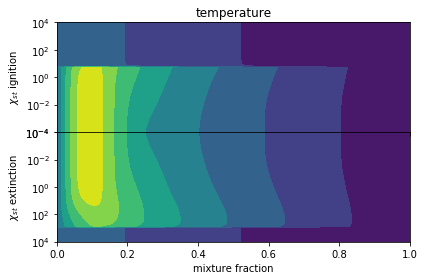

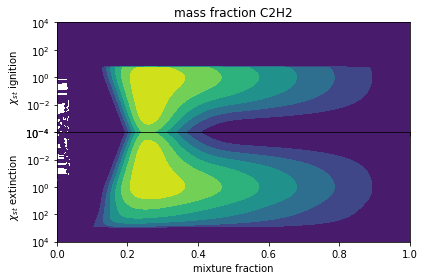

/opt/anaconda3/envs/spitfire/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  after removing the cwd from sys.path.
/opt/anaconda3/envs/spitfire/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


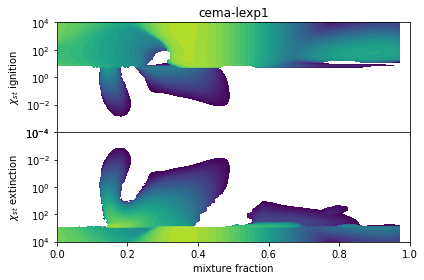

In [6]:
ld = libraries['dme 1200 K']

make_ignext_plot(ld, 'temperature')
make_ignext_plot(ld, 'mass fraction C2H2')
make_ignext_plot(ld, 'cema-lexp1', np.logspace(-2, 4, 40), LogNorm(vmin=1.e-2, vmax=1e4))

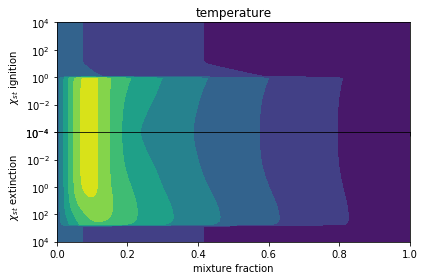

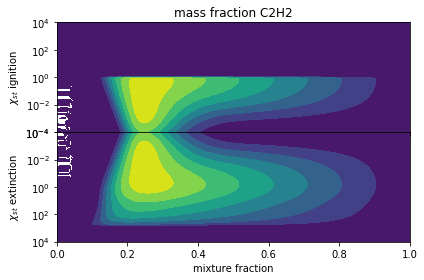

/opt/anaconda3/envs/spitfire/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  after removing the cwd from sys.path.
/opt/anaconda3/envs/spitfire/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


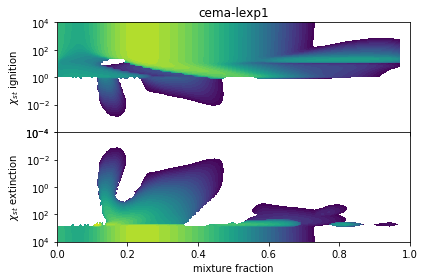

In [7]:
ld = libraries['dme 1000 K']

make_ignext_plot(ld, 'temperature')
make_ignext_plot(ld, 'mass fraction C2H2')
make_ignext_plot(ld, 'cema-lexp1', np.logspace(-2, 4, 40), LogNorm(vmin=1.e-2, vmax=1e4))

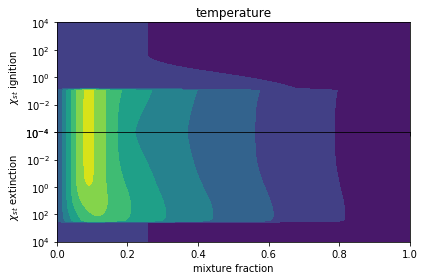

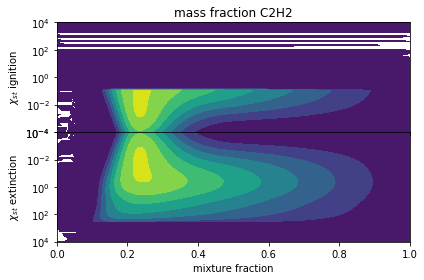

/opt/anaconda3/envs/spitfire/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  after removing the cwd from sys.path.
/opt/anaconda3/envs/spitfire/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


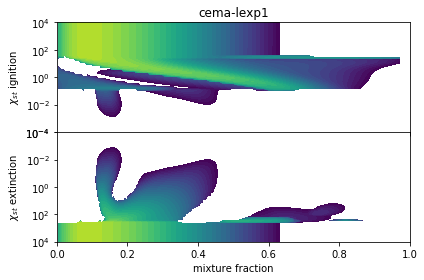

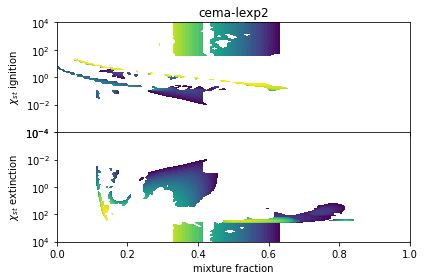

In [8]:
ld = libraries['dme 800 K']

make_ignext_plot(ld, 'temperature')
make_ignext_plot(ld, 'mass fraction C2H2')
make_ignext_plot(ld, 'cema-lexp1', np.logspace(-2, 4, 40), LogNorm(vmin=1.e-2, vmax=1e4))
make_ignext_plot(ld, 'cema-lexp2', np.logspace(-2, 2, 40), LogNorm(vmin=1.e-2, vmax=1e2))